# DDoS Network Traffic Detection Analysis

This notebook presents a complete analysis of DDoS detection using machine learning techniques. We'll cover:
1. Data Loading and Preprocessing
2. Exploratory Data Analysis
3. Feature Engineering
4. Model Training and Evaluation
5. Results Analysis and Deployment Considerations

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import joblib
import datetime
import pickle
import time

## 1. Data Loading and Initial Exploration

In [2]:
# Load data
file_path = "data_processed.csv"
df = pd.read_csv(file_path)
print(f"Dataset Loaded. Shape: {df.shape}")

# Display first few rows and basic information
print("\nFirst few rows of the dataset:")
display(df.head())

print("\nDataset Info:")
df.info()

Dataset Loaded. Shape: (225743, 85)

First few rows of the dataset:


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225743 entries, 0 to 225742
Data columns (total 85 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow ID                      225743 non-null  object 
 1   Source IP                    225743 non-null  object 
 2   Source Port                  225743 non-null  int64  
 3   Destination IP               225743 non-null  object 
 4   Destination Port             225743 non-null  int64  
 5   Protocol                     225743 non-null  int64  
 6   Timestamp                    225743 non-null  object 
 7   Flow Duration                225743 non-null  int64  
 8   Total Fwd Packets            225743 non-null  int64  
 9   Total Backward Packets       225743 non-null  int64  
 10  Total Length of Fwd Packets  225743 non-null  int64  
 11  Total Length of Bwd Packets  225743 non-null  int64  
 12  Fwd Packet Length Max        225743 non-nul

## 2. Data Cleaning and Preprocessing

In [3]:
# Clean column names
df.columns = df.columns.str.strip()

# Handle inf/nan values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
initial_shape = df.shape
df.dropna(inplace=True)
print(f"Removed {initial_shape[0] - df.shape[0]} rows with missing values")

# Remove duplicates
initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f"Removed {initial_shape[0] - df.shape[0]} duplicate rows")

# Display class distribution
print("\nLabel Distribution:")
print(df["Label"].value_counts())
print("\nLabel Distribution (%):")
print(df["Label"].value_counts(normalize=True) * 100)

Removed 0 rows with missing values
Removed 0 duplicate rows

Label Distribution:
Label
DDoS      128027
BENIGN     97716
Name: count, dtype: int64

Label Distribution (%):
Label
DDoS      56.713608
BENIGN    43.286392
Name: proportion, dtype: float64


## 3. Exploratory Data Analysis

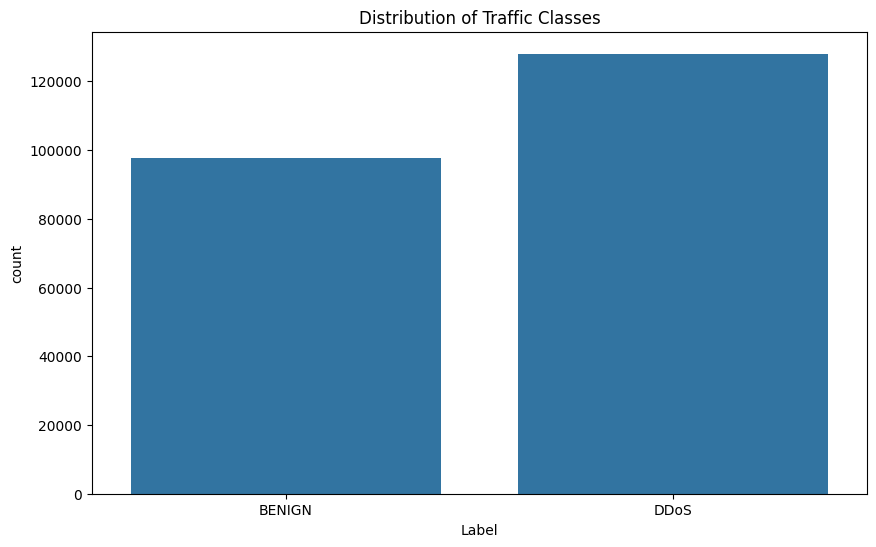

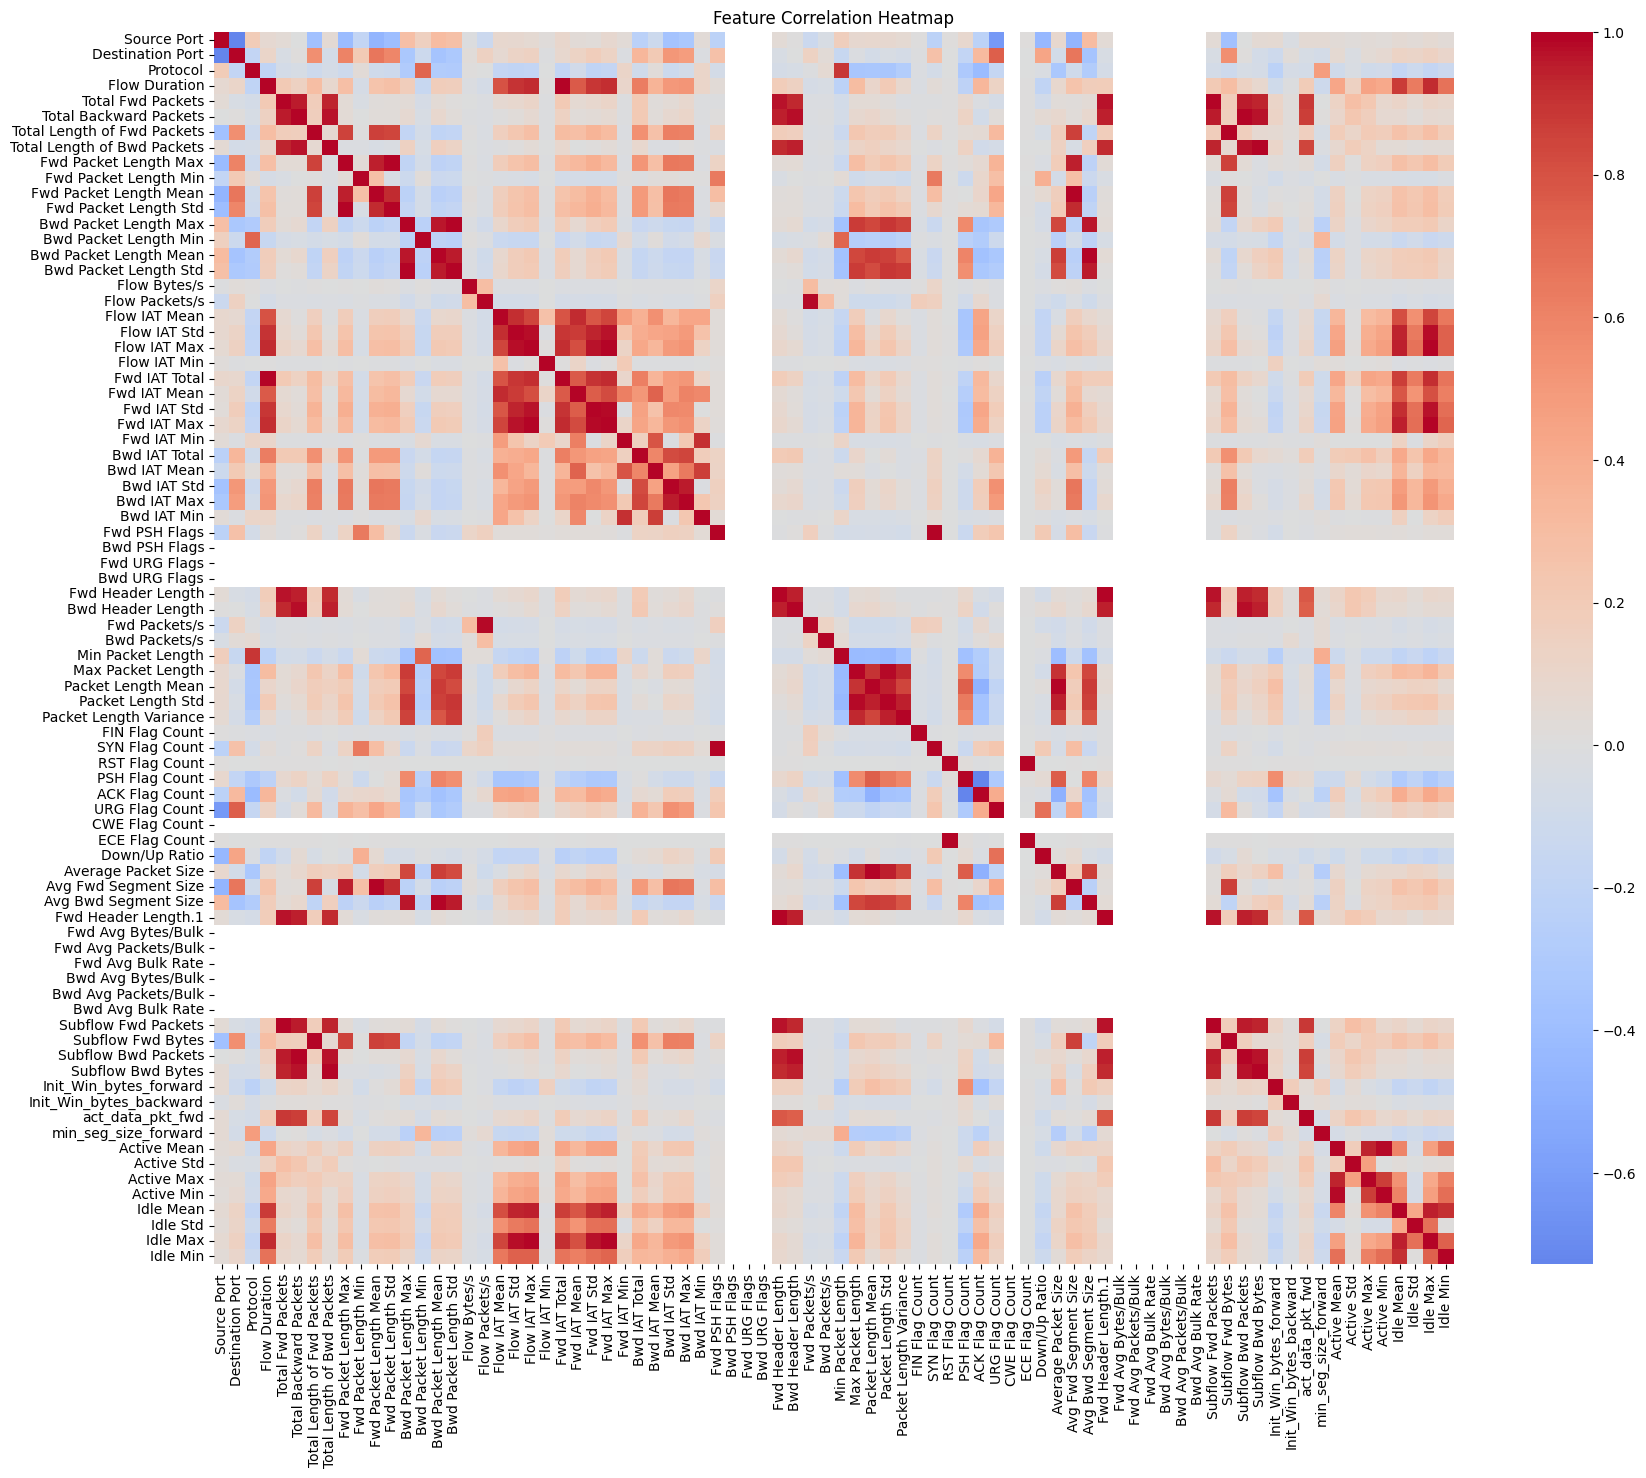


Numerical Features Statistics:


,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,225743.000000,225743.000000,225743.000000,2.257430e+05,225743.000000,225743.000000,225743.000000,2.257430e+05,225743.000000,225743.000000,...,225743.000000,225743.000000,2.257430e+05,2.257430e+05,2.257430e+05,2.257430e+05,2.257430e+05,2.257430e+05,2.257430e+05,2.257430e+05
mean,38257.432270,8879.575717,7.600302,1.624179e+07,4.874942,4.572815,939.471669,5.960530e+03,538.540464,27.882468,...,3.311527,21.482659,1.848277e+05,1.293447e+04,2.080867e+05,1.776217e+05,1.032223e+07,3.611975e+06,1.287824e+07,7.755424e+06
std,23057.358855,19754.718263,3.881601,3.152448e+07,15.422939,21.755448,3249.416675,3.921851e+04,1864.136559,163.324861,...,12.270068,4.166700,7.979284e+05,2.102746e+05,9.002388e+05,7.842635e+05,2.185310e+07,1.275695e+07,2.692136e+07,1.983117e+07
min,0.000000,0.000000,0.000000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,18989.500000,80.000000,6.000000,7.118200e+04,2.000000,1.000000,26.000000,0.000000e+00,6.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,49799.000000,80.000000,6.000000,1.452338e+06,3.000000,4.000000,30.000000,1.640000e+02,20.000000,0.000000,...,2.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,58296.000000,80.000000,6.000000,8.805241e+06,5.000000,5.000000,63.000000,1.160100e+04,34.000000,6.000000,...,4.000000,20.000000,1.878000e+03,0.000000e+00,1.878000e+03,1.862000e+03,8.239740e+06,0.000000e+00,8.253854e+06,7.422860e+06
max,65534.000000,65532.000000,17.000000,1.199999e+08,1932.000000,2942.000000,183012.000000,5.172346e+06,11680.000000,1472.000000,...,1931.000000,52.000000,1.000000e+08,3.950000e+07,1.000000e+08,1.000000e+08,1.200000e+08,6.530000e+07,1.200000e+08,1.200000e+08


In [4]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x="Label", data=df)
plt.title("Distribution of Traffic Classes")
plt.show()

# Correlation analysis
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(20, 16))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Basic statistics of numerical features
print("\nNumerical Features Statistics:")
display(numeric_df.describe())

## 4. Feature Engineering

In [22]:
# Encode categorical variables
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])

# Drop non-relevant columns
drop_cols = ["Flow ID", "Source IP", "Destination IP", "Timestamp"]
df.drop(columns=drop_cols, errors="ignore", inplace=True)

# Handle categorical features
categorical_features = ["Source Port", "Destination Port", "Protocol"]
for col in categorical_features:
    if col in df.columns:
        freq_map = df[col].value_counts().to_dict()
        df[col] = df[col].map(freq_map)

# Drop highly correlated features
correlated_feature_pairs = [
    ("Active Max", "Active Min"),
    ("Average Packet Size", "Packet Length Mean"),
    ("Avg Bwd Segment Size", "Avg Fwd Segment Size"),
    ("Bwd Header Length", "Fwd Header Length"),
    ("Bwd IAT Max", "Bwd IAT Min"),
    ("Bwd Packet Length Mean", "Bwd Packet Length Std"),
    ("Flow IAT Max", "Flow IAT Std"),
    ("Fwd IAT Max", "Fwd IAT Total"),
    ("Fwd IAT Mean", "Fwd IAT Std"),
    ("Fwd Packet Length Mean", "Fwd Packet Length Std"),
    ("Idle Max", "Idle Min"),
    ("Subflow Bwd Packets", "Subflow Fwd Packets")
]
features_to_drop = set()
for feature1, feature2 in correlated_feature_pairs:
    features_to_drop.add(feature2)  # Drop one of the highly correlated pairs

df.drop(columns=features_to_drop, errors="ignore", inplace=True)

print("Feature engineering completed.")
print(f"Final dataset shape: {df.shape}")

Feature engineering completed.
Final dataset shape: (225743, 69)


## 5. Data Split and Scaling

In [23]:
# Prepare features and target
X = df.drop(columns=["Label"])
y = df["Label"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")

Training set shape: (158020, 68)
Testing set shape: (67723, 68)


In [24]:
# Define parameter grids
param_grids = {
    "Logistic Regression": {
        "C": [0.1, 1, 10],
        "class_weight": ["balanced"],
        "max_iter": [1000]
    },
    "Random Forest": {
        "n_estimators": [50, 100],
        "max_depth": [None, 10, 20],
        "class_weight": ["balanced"],
        "min_samples_split": [2, 5]
    },
    "XGBoost": {
        "n_estimators": [50, 100],
        "max_depth": [4, 6],
        "learning_rate": [0.1, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "MLP Neural Network": {
        "hidden_layer_sizes": [(128, 64), (64, 32)],
        "max_iter": [300, 500],
        "learning_rate_init": [0.001, 0.01]
    }
}

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "MLP Neural Network": MLPClassifier(random_state=42)
}

# Train and tune models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_models = {}
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    grid_search = GridSearchCV(
        model, param_grids[name],
        cv=cv, scoring='f1',
        n_jobs=-1, verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    best_models[name] = grid_search.best_estimator_
    
    results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'test_score': grid_search.score(X_test_scaled, y_test)
    }
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")

# Display results summary
results_df = pd.DataFrame({
    name: {
        'CV F1-Score': res['best_score'],
        'Test F1-Score': res['test_score']
    } for name, res in results.items()
}).round(4)

print("\nModel Comparison:")
display(results_df)


Training Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000}
Best CV score: 0.9995

Training Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best CV score: 0.9999

Training XGBoost...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50, 'subsample': 1.0}
Best CV score: 0.9999

Training MLP Neural Network...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'max_iter': 300}
Best CV score: 0.9999

Model Comparison:


,Logistic Regression,Random Forest,XGBoost,MLP Neural Network
CV F1-Score,0.9995,0.9999,0.9999,0.9999
Test F1-Score,0.9994,1.0000,0.9999,0.9999


## 7. Model Evaluation


Evaluating Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29315
           1       1.00      1.00      1.00     38408

    accuracy                           1.00     67723
   macro avg       1.00      1.00      1.00     67723
weighted avg       1.00      1.00      1.00     67723



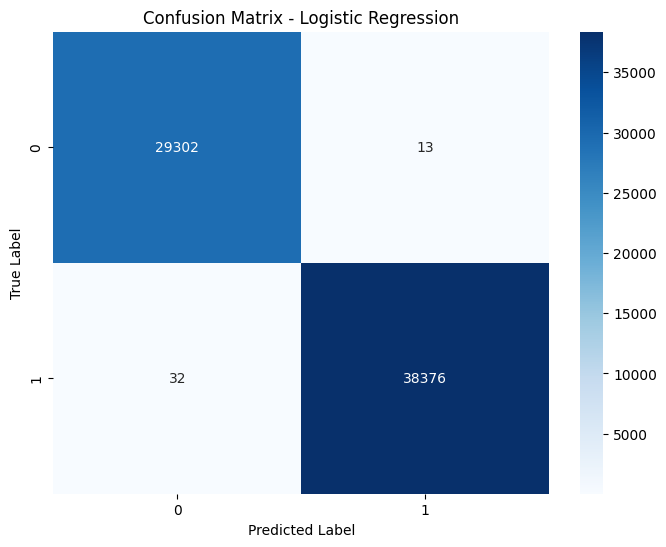

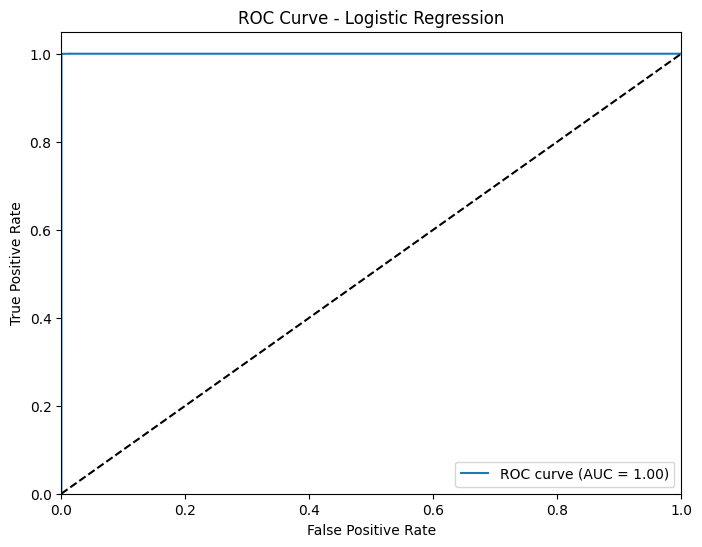


Evaluating Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29315
           1       1.00      1.00      1.00     38408

    accuracy                           1.00     67723
   macro avg       1.00      1.00      1.00     67723
weighted avg       1.00      1.00      1.00     67723



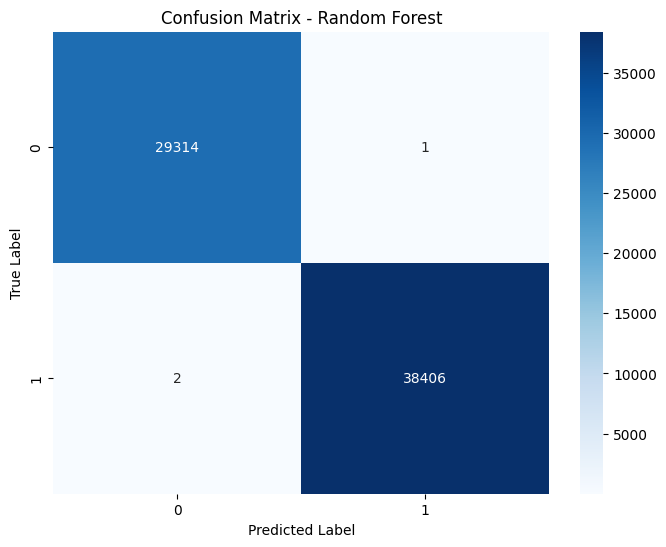

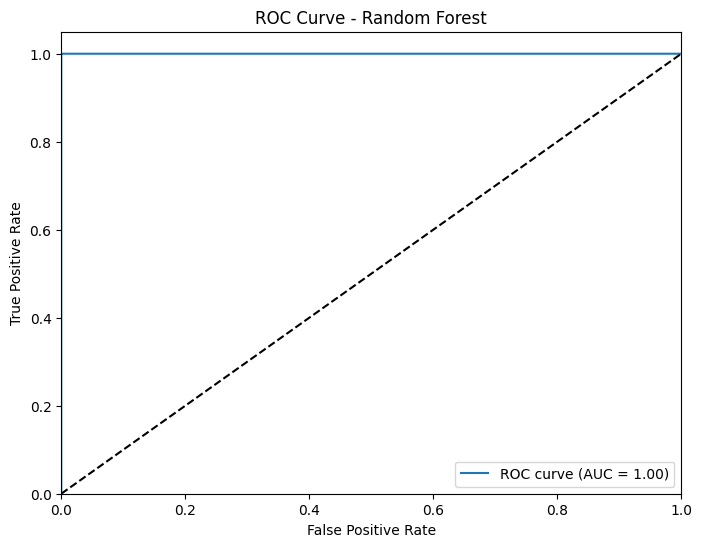


Evaluating XGBoost...

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29315
           1       1.00      1.00      1.00     38408

    accuracy                           1.00     67723
   macro avg       1.00      1.00      1.00     67723
weighted avg       1.00      1.00      1.00     67723



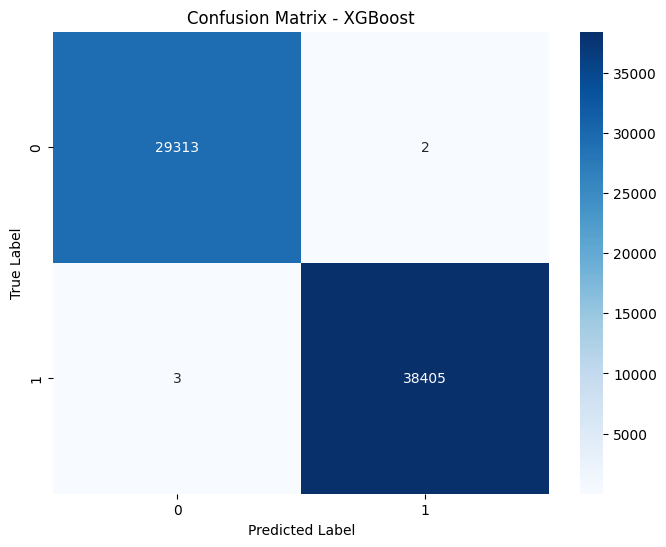

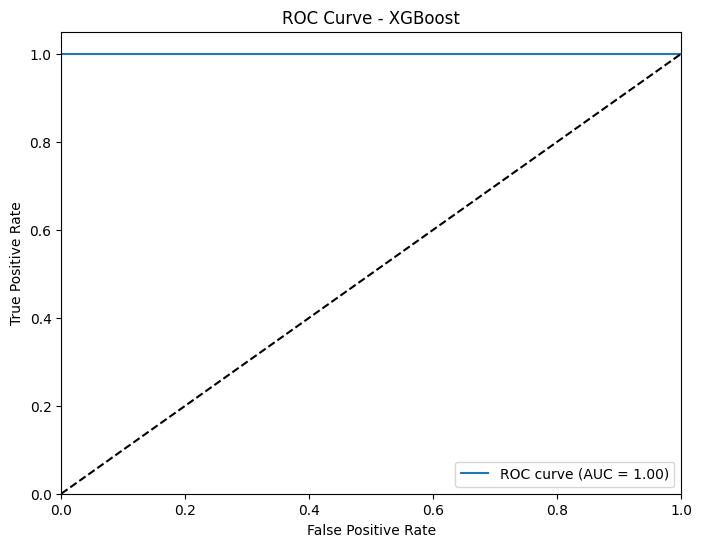


Evaluating MLP Neural Network...

MLP Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29315
           1       1.00      1.00      1.00     38408

    accuracy                           1.00     67723
   macro avg       1.00      1.00      1.00     67723
weighted avg       1.00      1.00      1.00     67723



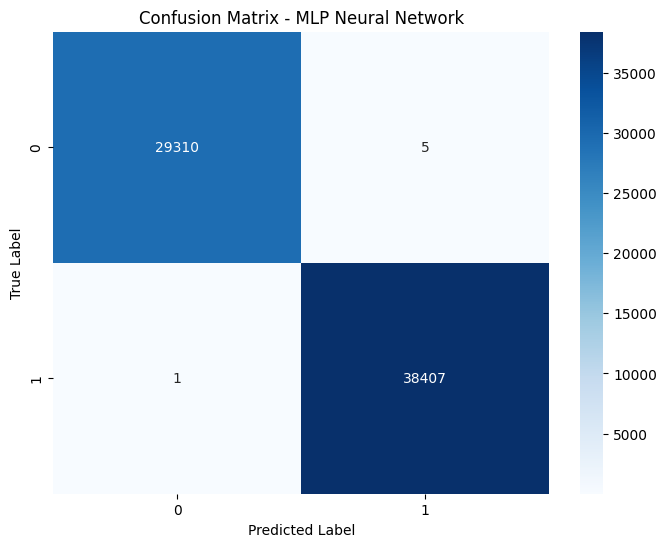

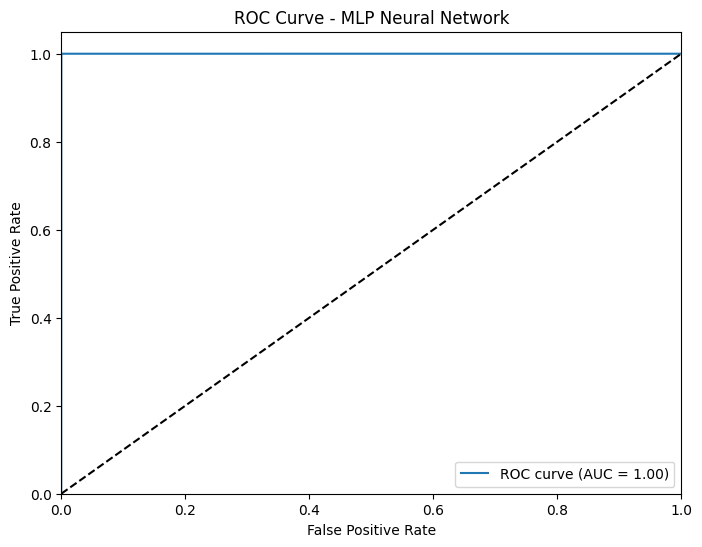


Final Model Comparison:


,Logistic Regression,Random Forest,XGBoost,MLP Neural Network
accuracy,0.9993,1.0000,0.9999,0.9999
precision,0.9997,1.0000,0.9999,0.9999
recall,0.9992,0.9999,0.9999,1.0000
f1,0.9994,1.0000,0.9999,0.9999
roc_auc,0.9998,1.0000,1.0000,1.0000


In [25]:
def evaluate_model(name, model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }
    
    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {metrics["roc_auc"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()
    
    return metrics

# Evaluate all models
evaluation_results = {}
for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    evaluation_results[name] = evaluate_model(name, model, X_test_scaled, y_test)

# Create comparison DataFrame
comparison_df = pd.DataFrame(evaluation_results).round(4)
print("\nFinal Model Comparison:")
display(comparison_df)

## 8. Feature Importance Analysis

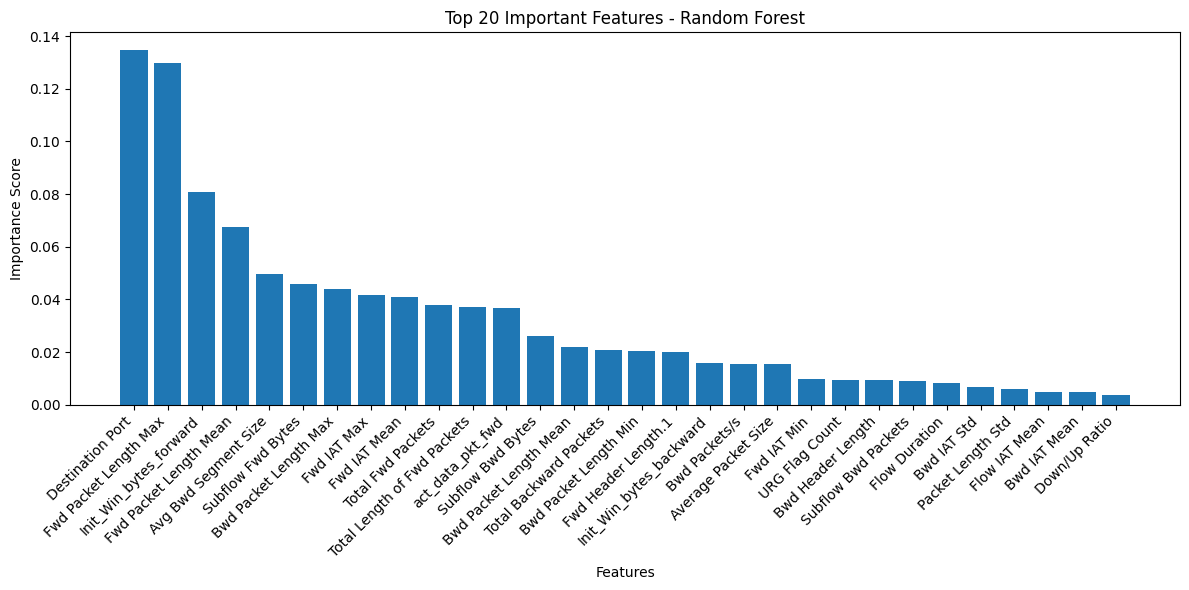

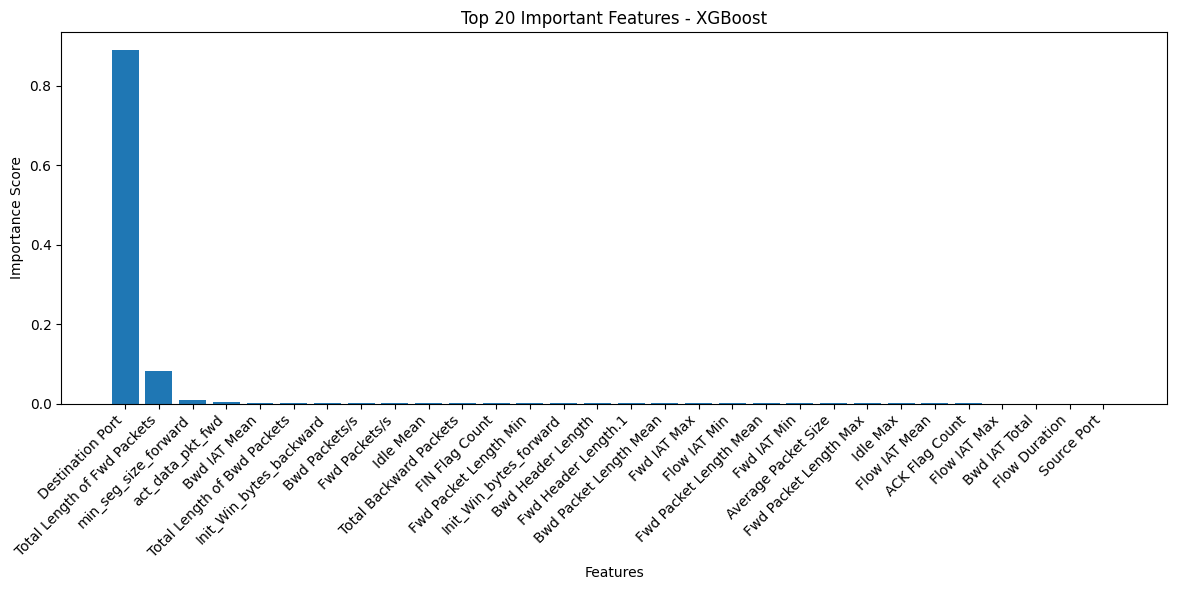

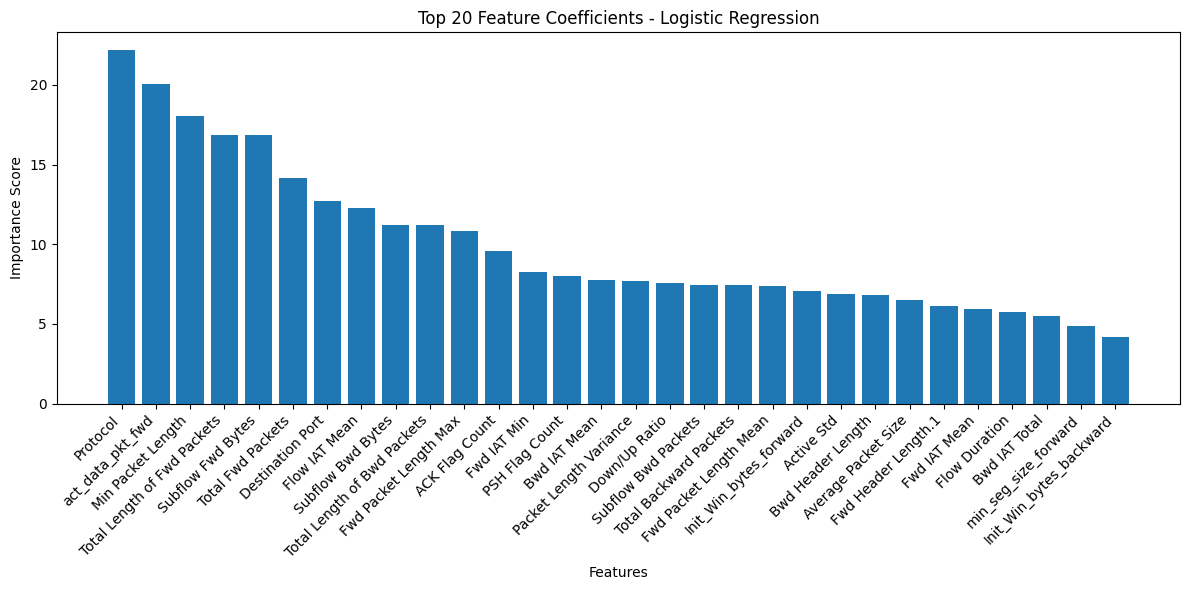

In [26]:
def plot_feature_importance(model, feature_names, title, top_n=30):
    plt.figure(figsize=(12, 6))
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print("Model doesn't support direct feature importance extraction")
        return
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:top_n]
    
    # Plot
    plt.bar(range(top_n), importances[top_indices])
    plt.xticks(range(top_n), [feature_names[i] for i in top_indices], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Get feature names
feature_names = X.columns.tolist()

# Plot feature importance for tree-based models
for name in ["Random Forest", "XGBoost"]:
    if name in best_models:
        plot_feature_importance(
            best_models[name],
            feature_names,
            f"Top 20 Important Features - {name}"
        )

# For logistic regression
if "Logistic Regression" in best_models:
    plot_feature_importance(
        best_models["Logistic Regression"],
        feature_names,
        "Top 20 Feature Coefficients - Logistic Regression"
    )

## 9. Model Performance Analysis

Analyzing performance of best model: Random Forest


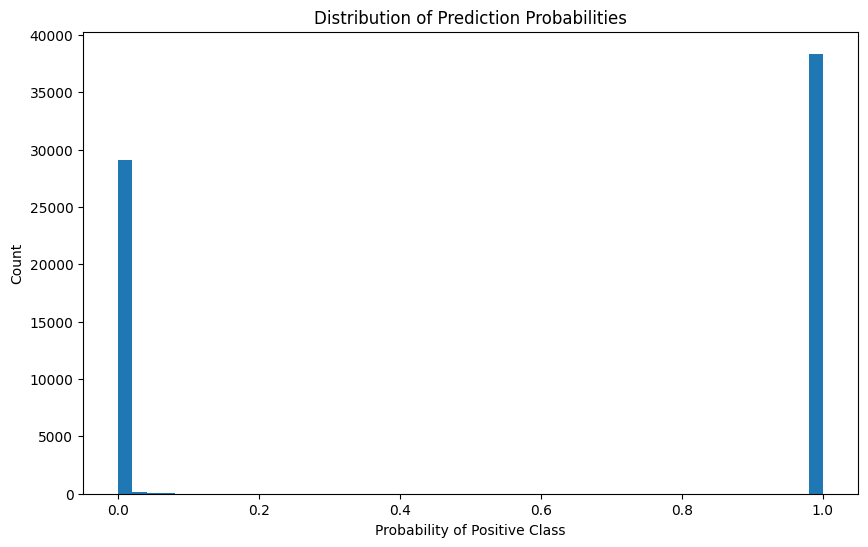

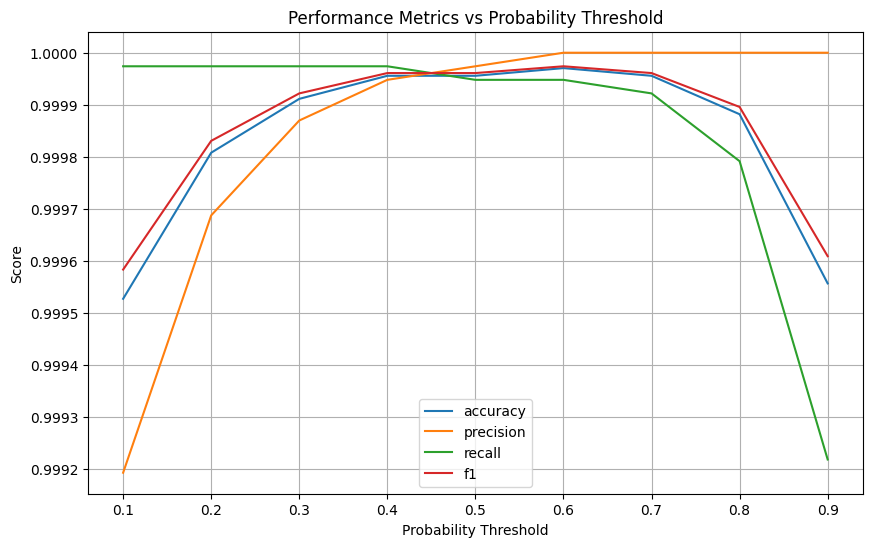

Average prediction time: 0.054 ms per sample


In [27]:
def analyze_prediction_performance(model, X_test, y_test):
    # Measure prediction time
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    prediction_time = (end_time - start_time) / len(X_test) * 1000  # ms per sample
    
    # Get prediction probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Analyze prediction confidence
    plt.figure(figsize=(10, 6))
    plt.hist(y_proba, bins=50)
    plt.title('Distribution of Prediction Probabilities')
    plt.xlabel('Probability of Positive Class')
    plt.ylabel('Count')
    plt.show()
    
    # Performance at different probability thresholds
    thresholds = np.arange(0.1, 1.0, 0.1)
    threshold_metrics = []
    
    for threshold in thresholds:
        y_pred_threshold = (y_proba >= threshold).astype(int)
        threshold_metrics.append({
            'threshold': threshold,
            'accuracy': accuracy_score(y_test, y_pred_threshold),
            'precision': precision_score(y_test, y_pred_threshold),
            'recall': recall_score(y_test, y_pred_threshold),
            'f1': f1_score(y_test, y_pred_threshold)
        })
    
    # Plot metrics vs threshold
    metrics_df = pd.DataFrame(threshold_metrics)
    plt.figure(figsize=(10, 6))
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        plt.plot(metrics_df['threshold'], metrics_df[metric], label=metric)
    plt.xlabel('Probability Threshold')
    plt.ylabel('Score')
    plt.title('Performance Metrics vs Probability Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return prediction_time

# Analyze best model
best_model_name = max(evaluation_results.items(), key=lambda x: x[1]['f1'])[0]
best_model = best_models[best_model_name]

print(f"Analyzing performance of best model: {best_model_name}")
avg_prediction_time = analyze_prediction_performance(best_model, X_test_scaled, y_test)
print(f"Average prediction time: {avg_prediction_time:.3f} ms per sample")

## 10. Save Best Model

In [28]:
import json

In [29]:
# Create directory for model artifacts
output_dir = f"model_artifacts_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}"
os.makedirs(output_dir, exist_ok=True)

# Save model and scaler
model_path = os.path.join(output_dir, 'best_model.pkl')
scaler_path = os.path.join(output_dir, 'scaler.pkl')

joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)

# Save model info
model_info = {
    'model_name': best_model_name,
    'feature_names': feature_names,
    'metrics': evaluation_results[best_model_name],
    'best_parameters': results[best_model_name]['best_params'],
    'training_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(os.path.join(output_dir, 'model_info.json'), 'w') as f:
    json.dump(model_info, f, indent=4)

print(f"Model artifacts saved in: {output_dir}")

Model artifacts saved in: model_artifacts_20250224_1400
